## Project 3: House Price Prediction using TensorFlow Functional API
#### CSC 180 Intelligent Systems
#### Derek Chen, Nicolas Gugliemo, Xai Yang, Katrina Yu
## WARNING: RESTART KERNEL EACH RUN OR MODEL WILL NOT WORK. IF MODEL IS NOT LEARNING, TRY RESTARTING THE KERNEL UNTIL IT WORKS.
### Step 1: Import

In [ ]:
%reset -f # Try to reset variables to fix issues
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from IPython.display import Image
from sklearn import preprocessing, metrics
from matplotlib.pyplot import figure, show
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv1D, MaxPooling1D, MaxPooling2D, Conv2D, Embedding, concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers,layers, Model, Input
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn import svm, datasets
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from collections.abc import Sequence
from tensorflow.keras.utils import plot_model
from keras.preprocessing import sequence

Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  try, please run `%reset?` for details
Don't know how to reset  to, please run `%reset?` for details
Don't know how to reset  reset, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details
Don't know how to reset  to, please run `%reset?` for details
Don't know how to reset  fix, please run `%reset?` for details
Don't know how to reset  issues, please run `%reset?` for details


### Step 2: Functions
### Nicolas Gugliemo

In [ ]:

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        print('CLASS')
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        print('REG')
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Function to plot results
def plot(results):
    fig, ax = plt.subplots(figsize=(10, 6))

    for activation in results['Activation'].unique():
        subset = results[results['Activation'] == activation]
        ax.plot(subset['Neurons'].astype(str), subset['RMSE'], marker='o', label=activation)

    ax.set_title('Model Performance by Activation Function')
    ax.set_xlabel('Layer Configuration (Neurons)')
    ax.set_ylabel('RMSE')
    ax.legend(title='Activation Function')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    plt.plot(t['pred'].tolist(), label='Prediction', color='orange')
    plt.plot(t['y'].tolist(), label='Expected', color='blue')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)
    return df

# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low



### Step 3: Import data and create tables
### Nicolas Gugliemo

In [ ]:
filename_read = os.path.join("data/HousesInfo.txt")
cols=["Bedrooms","Bathrooms","area","zipcode","price"]
df = pd.read_csv(filename_read , sep=" ", header=None , names=cols)
df.shape


(535, 5)

### Step 4: Drop Outliers and save which indexes were dropped to match the for the img table
### Nicolas Gugliemo

In [ ]:
outlier= df.index[df['price'] <= 50000].tolist()
outlier1= df.index[df['price'] >= 900000].tolist()
outlier= outlier+outlier1
df = df.loc[(df['price'] > 50000) & (df['price'] < 900000)]
df.head()

,Bedrooms,Bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
6,3,4.0,2544,85262,799000
10,5,5.0,4829,85266,519200


### Step 5: Create Img Table
### Nicolas Gugliemo

In [ ]:
## Bathroom.jpg
new_images=[]
for number in range(1, 536):
    for path in glob.glob("data/Houses dataset/" + str(number) + "_bathroom.jpg"):
        if os.path.isfile(path):
            new_images.append(path)
img= pd.DataFrame(new_images,columns = ['bathroom_img'])
## bedroom images
bedroom_images = []
for number in range(1, 536):
    for path in glob.glob("data/Houses dataset/" + str(number) + "_bedroom.jpg"):
        if os.path.isfile(path):
            bedroom_images.append(path)
img['bedroom_img']=bedroom_images
frontal_images = []
for number in range(1, 536):
    for path in glob.glob("data/Houses dataset/" + str(number) + "_frontal.jpg"):
        if os.path.isfile(path):
            frontal_images.append(path)
img['frontal_img']=frontal_images
kitchen_images = []
for number in range(1, 536):
    for path in glob.glob("data/Houses dataset/" + str(number) + "_kitchen.jpg"):
        if os.path.isfile(path):
            kitchen_images.append(path)
img['kitchen_img']=kitchen_images

In [ ]:
img.head()

,bathroom_img,bedroom_img,frontal_img,kitchen_img
0,data/Houses dataset/1_bathroom.jpg,data/Houses dataset/1_bedroom.jpg,data/Houses dataset/1_frontal.jpg,data/Houses dataset/1_kitchen.jpg
1,data/Houses dataset/2_bathroom.jpg,data/Houses dataset/2_bedroom.jpg,data/Houses dataset/2_frontal.jpg,data/Houses dataset/2_kitchen.jpg
2,data/Houses dataset/3_bathroom.jpg,data/Houses dataset/3_bedroom.jpg,data/Houses dataset/3_frontal.jpg,data/Houses dataset/3_kitchen.jpg
3,data/Houses dataset/4_bathroom.jpg,data/Houses dataset/4_bedroom.jpg,data/Houses dataset/4_frontal.jpg,data/Houses dataset/4_kitchen.jpg
4,data/Houses dataset/5_bathroom.jpg,data/Houses dataset/5_bedroom.jpg,data/Houses dataset/5_frontal.jpg,data/Houses dataset/5_kitchen.jpg


### Step 6: Ensure the indexes line up. Drop the rows that were dropped in the text table
### Nicolas Gugliemo

In [ ]:
img.shape # Before

(535, 4)

In [ ]:

img = img.drop(outlier)
img.shape # After

(452, 4)

### Step 7: Create Images and fit 4 images into 1
### Nicolas Gugliemo

In [ ]:
images_output=[]

for row_index,row in img.iterrows():
            inputImages=[]
            outputImage = np.zeros((128, 128, 3), dtype="uint8")
            image_temp1 = cv2.imread(row.bathroom_img)
            image1 = cv2.resize(image_temp1, (64 , 64))

            image_temp2 = cv2.imread(row.bedroom_img)
            image2 = cv2.resize(image_temp2, (64 , 64))

            image_temp3 = cv2.imread(row.frontal_img)
            image3 = cv2.resize(image_temp3, (64 , 64))

            image_temp4 = cv2.imread(row.kitchen_img)
            image4 = cv2.resize(image_temp4, (64 , 64))

            inputImages.append(image1)
            inputImages.append(image2)
            inputImages.append(image3)
            inputImages.append(image4)

            outputImage[0:64, 0:64] = inputImages[0]
            outputImage[0:64, 64:128] = inputImages[1]
            outputImage[64:128, 64:128] = inputImages[2]
            outputImage[64:128, 0:64] = inputImages[3]


            images_output.append(outputImage)

### Step 8: Ensure format is correct for img
### Nicolas Gugliemo

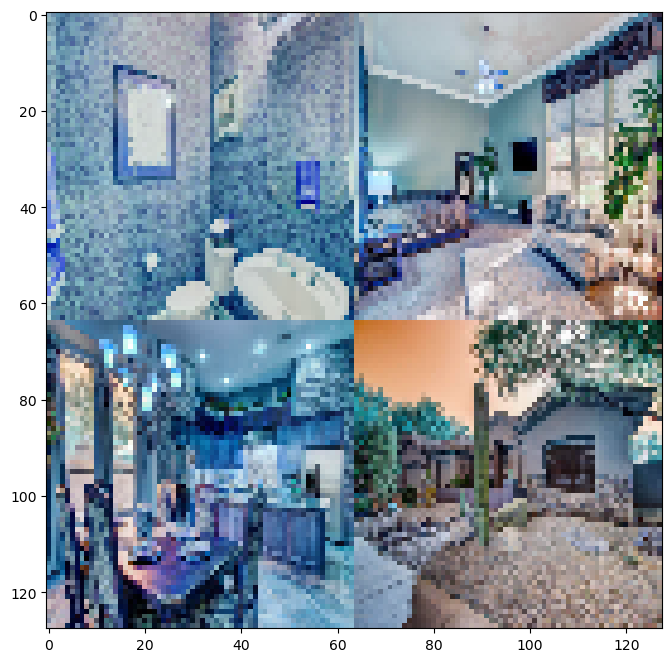

In [ ]:
from matplotlib import pyplot as plt

for i in images_output[:1]:
     plt.figure(figsize=(8,8))
     plt.imshow(i, interpolation='nearest')
     plt.show()

### Step 9: Get our img_arry ready for model evaluation. The shape needs to be 4d array
### Nicolas Gugliemo

In [ ]:
img_arr=np.asarray(images_output)
img_arr.shape

(452, 128, 128, 3)

### Step 10: Encode data
### Nicolas Gugliemo

In [ ]:
NumericColumns = ['area']
CategoricalColumns = ['zipcode','Bedrooms','Bathrooms']

for i in NumericColumns:
    encode_numeric_zscore(df,i)
for i in CategoricalColumns:
    encode_text_dummy(df,i)

df.head()

,area,price,zipcode-36372,zipcode-60002,zipcode-60016,zipcode-60046,zipcode-62025,zipcode-62034,zipcode-62088,zipcode-62214,...,Bathrooms-1.5,Bathrooms-2.0,Bathrooms-2.5,Bathrooms-3.0,Bathrooms-3.25,Bathrooms-3.5,Bathrooms-4.0,Bathrooms-4.5,Bathrooms-5.0,Bathrooms-6.0
0,1.652649,869500,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,1.022859,865200,True,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,1.537335,889000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
6,0.314122,799000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
10,2.340984,519200,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


### Step 11: Check shape and drop target col to prepare for model
### Nicolas Gugliemo

In [ ]:
df.shape

(452, 63)

In [ ]:
x = df.drop(['price'], axis = 1)
y = df.loc[:, ['price']] # Our price table

In [ ]:
x

,area,zipcode-36372,zipcode-60002,zipcode-60016,zipcode-60046,zipcode-62025,zipcode-62034,zipcode-62088,zipcode-62214,zipcode-62234,...,Bathrooms-1.5,Bathrooms-2.0,Bathrooms-2.5,Bathrooms-3.0,Bathrooms-3.25,Bathrooms-3.5,Bathrooms-4.0,Bathrooms-4.5,Bathrooms-5.0,Bathrooms-6.0
0,1.652649,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,1.022859,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,1.537335,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
6,0.314122,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
10,2.340984,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,-0.109878,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
531,6.516230,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
532,-0.156003,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
533,0.108331,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [ ]:
y

,price
0,869500
1,865200
2,889000
6,799000
10,519200
...,...
530,399900
531,460000
532,407000
533,419000


### Step 12: Split all tables which include feature table, price table (target), and img table
### Nicolas Gugliemo

In [ ]:
# df = text table
# img_arr = images table
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42)

In [ ]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(316, 62) (136, 62) (316, 1) (136, 1)


In [ ]:
img_train, img_test = train_test_split(img_arr, test_size=0.30, random_state=42)
print(img_train.shape, img_test.shape)

(316, 128, 128, 3) (136, 128, 128, 3)


### Step 13: Define functional model. FCNN, CNN, and final FCNN models
### Nicolas Gugliemo

In [ ]:

#FCNN for text table
input_dim = x_train.shape[1]
fcnn_input = Input(shape=(input_dim,))
fcnn_hidden1 = Dense(256, activation="relu")(fcnn_input)
fcnn_hidden2 = Dense(128, activation="relu")(fcnn_hidden1)
fcnn_hidden3 = Dense(64, activation="relu")(fcnn_hidden2)
fcnn_hidden4 = Dense(32, activation="relu")(fcnn_hidden3)
fcnn_output = Dense(1, activation="relu")(fcnn_hidden4)

#CNN for pic table
cnn_input = Input(shape=(128, 128, 3))
cnn_conv1 = Conv2D(64, kernel_size=4, activation='relu')(cnn_input)
cnn_pool1 = MaxPooling2D(pool_size=(2, 2))(cnn_conv1)
cnn_conv2 = Conv2D(32, kernel_size=4, activation='relu')(cnn_pool1)
cnn_pool2 = MaxPooling2D(pool_size=(2, 2))(cnn_conv2)
cnn_flat = Flatten()(cnn_pool2)

# merge input models
combined = concatenate([fcnn_output, cnn_flat])

#Interpret Model after concat
hidden1 = Dense(20, activation='relu')(combined)
#hidden1 = Dropout(0.2)(hidden1)
hidden2 = Dense(10, activation='relu')(hidden1)
#hidden2 = Dropout(0.2)(hidden2)
final_output = Dense(1, activation='relu')(hidden2)

model = Model(inputs=[fcnn_input, cnn_input], outputs=final_output)

# summarize layers
print(model.summary())

# plot model
plot_model(model,show_shapes=True)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 62)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │     16,128 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 125, 125,  │      3,136 │ input_layer_7[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     32,896 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 62, 62,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      8,256 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 59, 59,    │     32,800 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │      2,080 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 29, 29,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         33 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 26912)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 26913)     │          0 │ dense_9[0][0],    │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 20)        │    538,280 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 10)        │        210 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1)         │         11 │ dense_11[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 633,830 (2.42 MB)

 Trainable params: 633,830 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

None
You must install pydot (`pip install pydot`) for `plot_model` to work.


## Step 14: Strange datatype error will sometimes occur. Fix this by ensuring correct data type
### Nicolas Gugliemo

In [ ]:
x_train = np.array(x_train, dtype=np.float32)
#img_train = np.array(img_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
#img_test = np.array(img_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)


## Step 15: Train and save the model
### Nicolas Gugliemo

In [ ]:
for i in range(2):
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=10, verbose=1, mode='auto')
    model.fit([x_train, img_train], y_train,batch_size=32,validation_data=([x_test, img_test], y_test),callbacks=[monitor],verbose=2,epochs=1000)
model.save("models/model.keras")

Epoch 1/1000
10/10 - 18s - 2s/step - loss: 242775375872.0000 - val_loss: 236949454848.0000
Epoch 2/1000
10/10 - 4s - 416ms/step - loss: 140231426048.0000 - val_loss: 59433742336.0000
Epoch 3/1000
10/10 - 4s - 431ms/step - loss: 67808854016.0000 - val_loss: 64292851712.0000
Epoch 4/1000
10/10 - 4s - 421ms/step - loss: 58917257216.0000 - val_loss: 56517779456.0000
Epoch 5/1000
10/10 - 4s - 428ms/step - loss: 56238374912.0000 - val_loss: 58729771008.0000
Epoch 6/1000
10/10 - 4s - 419ms/step - loss: 55594008576.0000 - val_loss: 56376721408.0000
Epoch 7/1000
10/10 - 3s - 347ms/step - loss: 55514910720.0000 - val_loss: 60046307328.0000
Epoch 8/1000
10/10 - 3s - 327ms/step - loss: 56608608256.0000 - val_loss: 56263233536.0000
Epoch 9/1000
10/10 - 4s - 427ms/step - loss: 54425456640.0000 - val_loss: 56729677824.0000
Epoch 10/1000
10/10 - 4s - 384ms/step - loss: 54134116352.0000 - val_loss: 58359123968.0000
Epoch 11/1000
10/10 - 3s - 346ms/step - loss: 54044794880.0000 - val_loss: 55914102784.0

### Step 16: Plot the results
### Nicolas Gugliemo

In [ ]:
pred = model.predict([x_test,img_test])
score = np.sqrt(metrics.mean_squared_error(y_test,pred))

print("RMSE: {}".format(score))
print("R2:",metrics.r2_score(y_test,pred))
print("MSE:", metrics.mean_squared_error(y_test, pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step
RMSE: 137796.375
R2: 0.6749794329420651
MSE: 18987842000.0


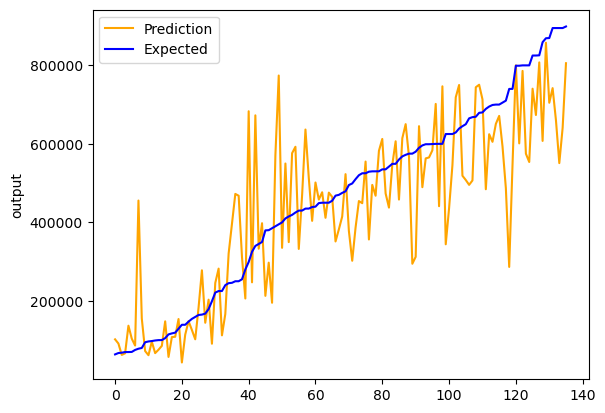

In [ ]:
model_pred = np.asarray(pred)
y_test_pred = np.asarray(y_test)

chart_regression(model_pred.flatten(),y_test_pred)

### Additional Feature: Transfer Learning Using VGG16
### Katrina Yu

# 1

In [ ]:
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16

img_transfer = Input(shape=(128, 128, 3))
x_transfer = Input(shape=(x_train.shape[1],))

# Train img with VGG16
vgg_model = VGG16(weights='imagenet', include_top=False, input_tensor=img_transfer)   #  first hidden layer

for layer in model.layers:
    layer.trainable = False

In [ ]:
img_process = vgg_model.output
img_process = Flatten()(img_process)

# Textual data trained seperately
x_process = Dense(20, activation='relu')(x_transfer)
fcnn_hidden1 = Dense(256, activation="relu")(x_process)
fcnn_hidden2 = Dense(128, activation="relu")(fcnn_hidden1)
fcnn_hidden3 = Dense(64, activation="relu")(fcnn_hidden2)
fcnn_hidden4 = Dense(32, activation="relu")(fcnn_hidden3)
fcnn_output = Dense(1, activation="relu")(fcnn_hidden4)

merged = concatenate([fcnn_output, img_process])

output = Dense(1, activation='relu')(merged)

model = Model(inputs=[x_transfer, img_transfer], outputs=output)

model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
model.fit([x_train, img_train], y_train,batch_size=64,validation_data=([x_test, img_test], y_test),callbacks=[monitor],verbose=2,epochs=1000)

Epoch 1/1000
5/5 - 14s - 3s/step - loss: 17044084883456.0000 - val_loss: 266961190912.0000
Epoch 2/1000
5/5 - 2s - 336ms/step - loss: 246852206592.0000 - val_loss: 240847568896.0000
Epoch 3/1000
5/5 - 2s - 330ms/step - loss: 284623306752.0000 - val_loss: 153009995776.0000
Epoch 4/1000
5/5 - 2s - 329ms/step - loss: 206562443264.0000 - val_loss: 263597670400.0000
Epoch 5/1000
5/5 - 3s - 536ms/step - loss: 246160228352.0000 - val_loss: 264015609856.0000
Epoch 6/1000
5/5 - 2s - 481ms/step - loss: 237984333824.0000 - val_loss: 211900170240.0000
Epoch 7/1000
5/5 - 2s - 356ms/step - loss: 127491825664.0000 - val_loss: 95289368576.0000
Epoch 8/1000
5/5 - 2s - 485ms/step - loss: 141600423936.0000 - val_loss: 160298795008.0000
Epoch 9/1000
5/5 - 2s - 362ms/step - loss: 102334808064.0000 - val_loss: 96145686528.0000
Epoch 10/1000
5/5 - 2s - 479ms/step - loss: 72582365184.0000 - val_loss: 91340267520.0000
Epoch 11/1000
5/5 - 3s - 508ms/step - loss: 68151631872.0000 - val_loss: 66095955968.0000
Epo

In [ ]:
from sklearn import metrics

model_pred = model.predict([x_test,img_test])

score = np.sqrt(metrics.mean_squared_error(y_test,model_pred))

print("Score (RMSE) : {}".format(score))
print("R2 score     :",metrics.r2_score(y_test,model_pred))
print("MSE          :", metrics.mean_squared_error(y_test, model_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step
Score (RMSE) : 145366.73365744407
R2 score     : 0.6382860541343689
MSE          : 21131487254.234283


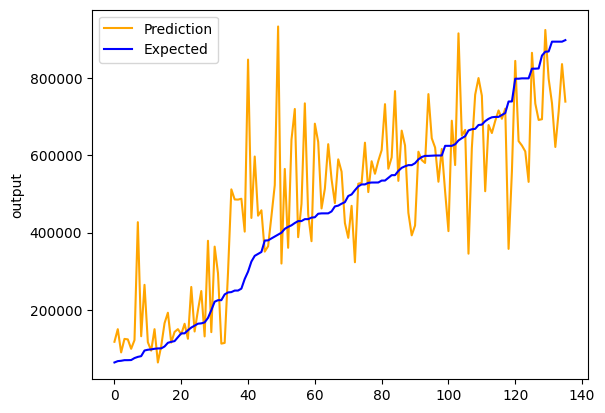

In [ ]:
model_pred = np.asarray(model_pred)
y_test_NN = np.asarray(y_test)

chart_regression(model_pred.flatten(),y_test_NN)

# 2

In [ ]:
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16

img_transfer = Input(shape=(128, 128, 3))
x_transfer = Input(shape=(x_train.shape[1],))

vgg_model = VGG16(weights='imagenet', include_top=False, input_tensor=img_transfer)   #  first hidden layer

for layer in model.layers:
    layer.trainable = False

In [ ]:
img_process = vgg_model.output
img_process = Flatten()(img_process)

x_process = Dense(20, activation='relu')(x_transfer)

merged = concatenate([x_process, img_process])

output = Dense(1, activation='relu')(merged)

model = Model(inputs=[x_transfer, img_transfer], outputs=output)

model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
model.fit([x_train, img_train], y_train,batch_size=64,validation_data=([x_test, img_test], y_test),callbacks=[monitor],verbose=2,epochs=1000)

Epoch 1/1000
5/5 - 11s - 2s/step - loss: 212152221696.0000 - val_loss: 261337923584.0000
Epoch 2/1000
5/5 - 6s - 1s/step - loss: 245344665600.0000 - val_loss: 262789677056.0000
Epoch 3/1000
5/5 - 2s - 460ms/step - loss: 228044259328.0000 - val_loss: 124626173952.0000
Epoch 4/1000
5/5 - 3s - 507ms/step - loss: 102334021632.0000 - val_loss: 147242074112.0000
Epoch 5/1000
5/5 - 3s - 508ms/step - loss: 122621976576.0000 - val_loss: 52276932608.0000
Epoch 6/1000
5/5 - 2s - 309ms/step - loss: 80412229632.0000 - val_loss: 99391799296.0000
Epoch 7/1000
5/5 - 2s - 343ms/step - loss: 78567243776.0000 - val_loss: 58362486784.0000
Epoch 8/1000
5/5 - 2s - 318ms/step - loss: 56456617984.0000 - val_loss: 54858641408.0000
Epoch 9/1000
5/5 - 3s - 505ms/step - loss: 48444559360.0000 - val_loss: 48209174528.0000
Epoch 10/1000
5/5 - 2s - 341ms/step - loss: 46055739392.0000 - val_loss: 50051477504.0000
Epoch 11/1000
5/5 - 2s - 312ms/step - loss: 50249388032.0000 - val_loss: 46478266368.0000
Epoch 12/1000
5

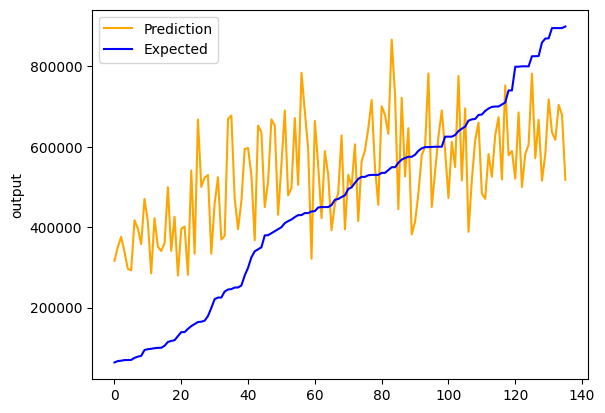

In [ ]:
model_pred = np.asarray(model_pred)
y_test_NN = np.asarray(y_test)

chart_regression(model_pred.flatten(),y_test_NN)

In [ ]:
from sklearn import metrics

model_pred = model.predict([x_test,img_test])

score = np.sqrt(metrics.mean_squared_error(y_test,model_pred))

print("Score (RMSE) : {}".format(score))
print("R2 score     :",metrics.r2_score(y_test,model_pred))
print("MSE          :", metrics.mean_squared_error(y_test, model_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step
Score (RMSE) : 212482.5953055444
R2 score     : 0.2271735668182373
MSE          : 45148853307.77976


# 3

In [ ]:
for i in range(5):
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model.fit([x_train, img_train], y_train,batch_size=32,validation_data=([x_test, img_test], y_test),callbacks=[monitor],verbose=2,epochs=1000)
model.save("models/model.keras")

Epoch 1/1000
10/10 - 9s - 852ms/step - loss: 240580837376.0000 - val_loss: 226404990976.0000
Epoch 2/1000
10/10 - 0s - 28ms/step - loss: 126171766784.0000 - val_loss: 71206526976.0000
Epoch 3/1000
10/10 - 0s - 24ms/step - loss: 64997576704.0000 - val_loss: 72928747520.0000
Epoch 4/1000
10/10 - 0s - 30ms/step - loss: 57402290176.0000 - val_loss: 56624504832.0000
Epoch 5/1000
10/10 - 0s - 22ms/step - loss: 56508747776.0000 - val_loss: 57995632640.0000
Epoch 6/1000
10/10 - 0s - 27ms/step - loss: 55219068928.0000 - val_loss: 56934076416.0000
Epoch 7/1000
10/10 - 0s - 25ms/step - loss: 55173935104.0000 - val_loss: 55931318272.0000
Epoch 8/1000
10/10 - 0s - 33ms/step - loss: 54583742464.0000 - val_loss: 58155491328.0000
Epoch 9/1000
10/10 - 0s - 26ms/step - loss: 54091378688.0000 - val_loss: 55936217088.0000
Epoch 10/1000
10/10 - 0s - 30ms/step - loss: 53932711936.0000 - val_loss: 56174088192.0000
Epoch 11/1000
10/10 - 0s - 31ms/step - loss: 53781561344.0000 - val_loss: 56130883584.0000
Epoc

In [ ]:
pred = model.predict([x_test,img_test])
score = np.sqrt(metrics.mean_squared_error(y_test,pred))

print("RMSE: {}".format(score))
print("R2:",metrics.r2_score(y_test,pred))
print("MSE:", metrics.mean_squared_error(y_test, pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
RMSE: 146505.515625
R2: 0.6325966119766235
MSE: 21463865000.0


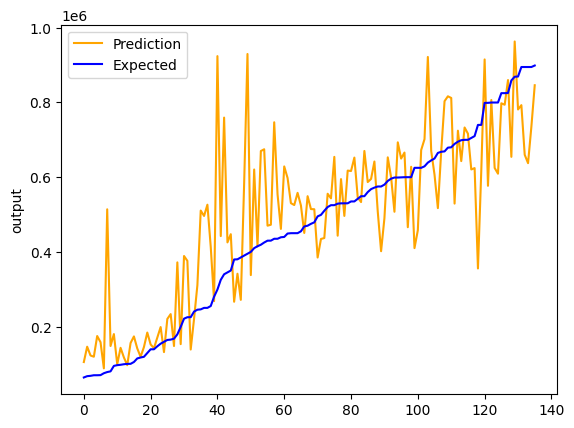

In [ ]:
model_pred = np.asarray(pred)
y_test_pred = np.asarray(y_test)

chart_regression(model_pred.flatten(),y_test_pred)

### Additional Feature: Transfer Learning Using RasNet50
### Xai Yang

Testing 1

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

input_image = Input(shape=(128, 128, 3))
input_x = Input(shape=(x_train.shape[1],))

# load model with pretrained weights
resnet_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_image)

# freeze the model
for layer in resnet_model.layers:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
x = resnet_model.output
x = Flatten()(x)
fc1 = Dense(256, activation='relu')(x)
fc2 = Dense(128, activation='relu')(fc1)
fc3 = Dense(64, activation='relu')(fc2)
fc4 = Dense(32, activation='relu')(fc3)
fc_output = Dense(1, activation='relu')(fc4)

# merge models
merge = concatenate([fc_output, x])
# prediction output
output = Dense(1, activation='relu')(merge)
# final model
model = Model(inputs = [input_x, input_image], outputs = output)

NameError: name 'resnet_model' is not defined

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
model.fit([x_train, img_train], y_train,batch_size=64,validation_data=([x_test, img_test], y_test),callbacks=[monitor],verbose=2,epochs=1000)

Epoch 1/1000
5/5 - 20s - 4s/step - loss: 248402132992.0000 - val_loss: 266939842560.0000
Epoch 2/1000
5/5 - 8s - 2s/step - loss: 248323309568.0000 - val_loss: 266847731712.0000
Epoch 3/1000
5/5 - 0s - 100ms/step - loss: 248227266560.0000 - val_loss: 266727292928.0000
Epoch 4/1000
5/5 - 1s - 118ms/step - loss: 248090820608.0000 - val_loss: 266545496064.0000
Epoch 5/1000
5/5 - 1s - 133ms/step - loss: 247872929792.0000 - val_loss: 266234560512.0000
Epoch 6/1000
5/5 - 1s - 121ms/step - loss: 247486922752.0000 - val_loss: 265663578112.0000
Epoch 7/1000
5/5 - 0s - 77ms/step - loss: 246787620864.0000 - val_loss: 264599339008.0000
Epoch 8/1000
5/5 - 1s - 124ms/step - loss: 245448916992.0000 - val_loss: 262642843648.0000
Epoch 9/1000
5/5 - 0s - 77ms/step - loss: 243100778496.0000 - val_loss: 259151151104.0000
Epoch 10/1000
5/5 - 1s - 132ms/step - loss: 238890958848.0000 - val_loss: 253117988864.0000
Epoch 11/1000
5/5 - 1s - 117ms/step - loss: 231622262784.0000 - val_loss: 243114278912.0000
Epoc

In [ ]:
from sklearn import metrics

model_pred = model.predict([x_test,img_test])

score = np.sqrt(metrics.mean_squared_error(y_test,model_pred))

print("Score (RMSE) : {}".format(score))
print("R2 score     :",metrics.r2_score(y_test,model_pred))
print("MSE          :", metrics.mean_squared_error(y_test, model_pred))

3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 762ms/step
Score (RMSE) : 209421.5
R2 score     : 0.2492803931236267
MSE          : 43857367000.0


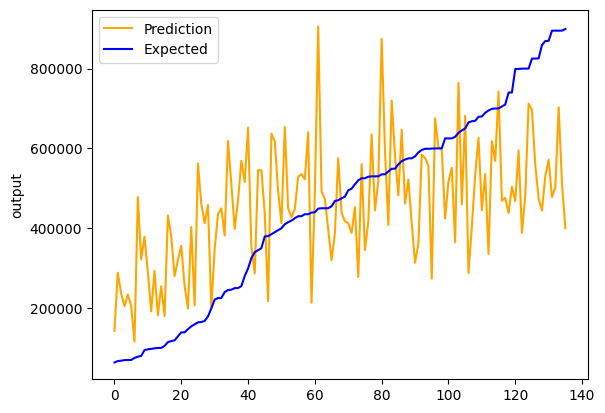

In [ ]:
model_pred = np.asarray(model_pred)
y_test_NN = np.asarray(y_test)

chart_regression(model_pred.flatten(),y_test_NN)

Testing 2

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

input_image = Input(shape=(128, 128, 3))
input_x = Input(shape=(x_train.shape[1],))

# load model with pretrained weights
resnet_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_image)

# freeze the model
for layer in resnet_model.layers:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
x = resnet_model.output
x = Flatten()(x)

x1 = Dense(20, activation='relu')(x)
# merge using concatenation
merge = concatenate([x1, x])
# no activation for last layer
output = Dense(1)(merge)
# final model
model = Model(inputs = [input_x, input_image], outputs = output)

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
model.fit([x_train, img_train], y_train,batch_size=64,validation_data=([x_test, img_test], y_test),callbacks=[monitor],verbose=2,epochs=1000)

Epoch 1/1000
5/5 - 20s - 4s/step - loss: 248395759616.0000 - val_loss: 266929831936.0000
Epoch 2/1000
5/5 - 0s - 87ms/step - loss: 248311349248.0000 - val_loss: 266835017728.0000
Epoch 3/1000
5/5 - 1s - 127ms/step - loss: 248217550848.0000 - val_loss: 266731208704.0000
Epoch 4/1000
5/5 - 0s - 89ms/step - loss: 248113233920.0000 - val_loss: 266616766464.0000
Epoch 5/1000
5/5 - 0s - 91ms/step - loss: 247999381504.0000 - val_loss: 266489790464.0000
Epoch 6/1000
5/5 - 0s - 90ms/step - loss: 247872831488.0000 - val_loss: 266349002752.0000
Epoch 7/1000
5/5 - 0s - 93ms/step - loss: 247735336960.0000 - val_loss: 266192551936.0000
Epoch 8/1000
5/5 - 1s - 120ms/step - loss: 247579574272.0000 - val_loss: 266020339712.0000
Epoch 9/1000
5/5 - 0s - 86ms/step - loss: 247410786304.0000 - val_loss: 265830514688.0000
Epoch 10/1000
5/5 - 0s - 81ms/step - loss: 247222419456.0000 - val_loss: 265623355392.0000
Epoch 11/1000
5/5 - 0s - 80ms/step - loss: 247012835328.0000 - val_loss: 265398992896.0000
Epoch 1

In [ ]:
from sklearn import metrics

model_pred = model.predict([x_test,img_test])

score = np.sqrt(metrics.mean_squared_error(y_test,model_pred))

print("Score (RMSE) : {}".format(score))
print("R2 score     :",metrics.r2_score(y_test,model_pred))
print("MSE          :", metrics.mean_squared_error(y_test, model_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 767ms/step
Score (RMSE) : 212817.5
R2 score     : 0.22473543882369995
MSE          : 45291290000.0


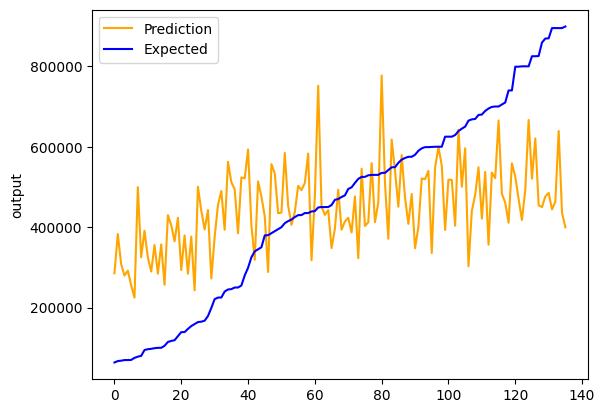

In [ ]:
model_pred = np.asarray(model_pred)
y_test_NN = np.asarray(y_test)

chart_regression(model_pred.flatten(),y_test_NN)

Testing 3

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

input_image = Input(shape=(128, 128, 3))
input_x = Input(shape=(x_train.shape[1],))

# load model with pretrained weights
resnet_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_image)

# freeze the model
for layer in resnet_model.layers:
    layer.trainable = False

In [ ]:
x = resnet_model.output
x = Flatten()(x)

x1 = Dense(20, activation='relu')(x)
# merge using concatenation
merge = concatenate([x1, x])
# no activation for last layer
output = Dense(1)(merge)
# final model
model = Model(inputs = [input_x, input_image], outputs = output)

In [ ]:
for i in range(2):
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=10, verbose=1, mode='auto')
    model.fit([x_train, img_train], y_train,batch_size=32,validation_data=([x_test, img_test], y_test),callbacks=[monitor],verbose=2,epochs=1000)
model.save("models/model.keras")

Epoch 1/1000
10/10 - 19s - 2s/step - loss: 248359469056.0000 - val_loss: 266842603520.0000
Epoch 2/1000
10/10 - 10s - 1s/step - loss: 248178556928.0000 - val_loss: 266636656640.0000
Epoch 3/1000
10/10 - 1s - 50ms/step - loss: 247962288128.0000 - val_loss: 266387193856.0000
Epoch 4/1000
10/10 - 1s - 62ms/step - loss: 247705665536.0000 - val_loss: 266083319808.0000
Epoch 5/1000
10/10 - 1s - 65ms/step - loss: 247388815360.0000 - val_loss: 265722413056.0000
Epoch 6/1000
10/10 - 1s - 64ms/step - loss: 247022157824.0000 - val_loss: 265293266944.0000
Epoch 7/1000
10/10 - 0s - 50ms/step - loss: 246585180160.0000 - val_loss: 264799895552.0000
Epoch 8/1000
10/10 - 0s - 50ms/step - loss: 246081404928.0000 - val_loss: 264237334528.0000
Epoch 9/1000
10/10 - 1s - 62ms/step - loss: 245512208384.0000 - val_loss: 263602143232.0000
Epoch 10/1000
10/10 - 1s - 50ms/step - loss: 244875837440.0000 - val_loss: 262891290624.0000
Epoch 11/1000
10/10 - 1s - 51ms/step - loss: 244171964416.0000 - val_loss: 262105

In [ ]:
from sklearn import metrics

model_pred = model.predict([x_test,img_test])

score = np.sqrt(metrics.mean_squared_error(y_test,model_pred))

print("Score (RMSE) : {}".format(score))
print("R2 score     :",metrics.r2_score(y_test,model_pred))
print("MSE          :", metrics.mean_squared_error(y_test, model_pred))

3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 791ms/step
Score (RMSE) : 207303.96875
R2 score     : 0.26438528299331665
MSE          : 42974933000.0


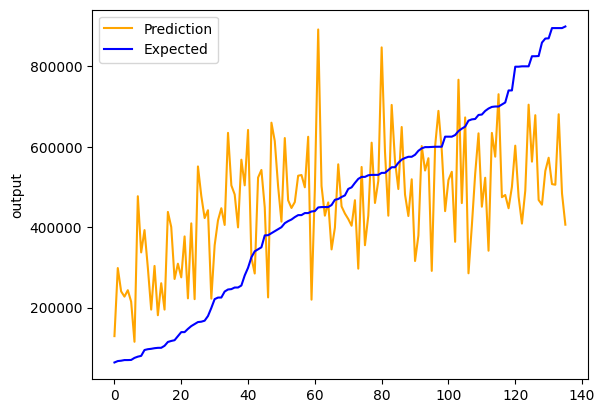

In [ ]:
model_pred = np.asarray(model_pred)
y_test_NN = np.asarray(y_test)

chart_regression(model_pred.flatten(),y_test_NN)

### Additional Feature: Transfer Learning Using MobileNetV2
### Derek Chen

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 392ms/step - loss: 245873459200.0000 - mse: 245873459200.0000 - val_loss: 267012358144.0000 - val_mse: 267012358144.0000
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - loss: 248910184448.0000 - mse: 248910184448.0000 - val_loss: 267006672896.0000 - val_mse: 267006672896.0000
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - loss: 239462891520.0000 - mse: 239462891520.0000 - val_loss: 266995171328.0000 - val_mse: 266995171328.0000
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - loss: 247265492992.0000 - mse: 247265492992.0000 - val_loss: 266966892544.0000 - val_mse: 266966892544.0000
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - loss: 242049302528.0000 - mse: 242049302528.0000 - val_loss: 266883743744.0000 - val_mse: 266883743744.0000
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - loss: 231069646848.0000 - mse: 231069646848.0000 - val_loss: 266643013632.0000 - val_mse: 266643013632.0000
Epoch 7/100
10/10 ━━━

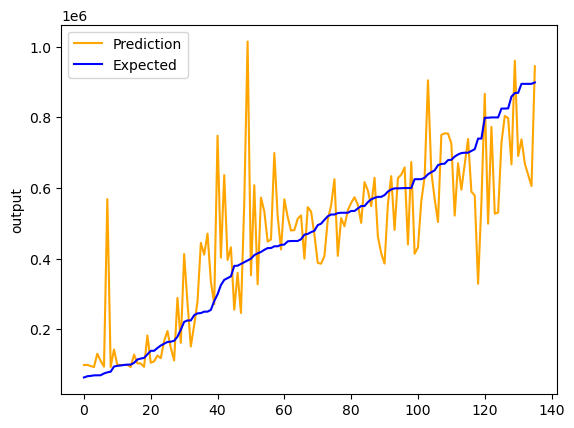

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
import numpy as np

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
img_train = preprocess_input(img_train)
img_test = preprocess_input(img_test)

# Training with MobileNetV2 model (pre-trained ImageNet weights while excluding the top layer)
MNetV2_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
for layer in MNetV2_model.layers:
    layer.trainable = False

# Add new top layers to pre-trained MobileNetV2
x = MNetV2_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(64, activation='relu')(x)

# FCNN for text features
input_dim = x_train.shape[1]
fcnn_input = Input(shape=(input_dim,))
fcnn_hidden1 = Dense(256, activation="relu")(fcnn_input)
fcnn_hidden2 = Dense(128, activation="relu")(fcnn_hidden1)
fcnn_hidden3 = Dense(64, activation="relu")(fcnn_hidden2)
fcnn_hidden4 = Dense(32, activation="relu")(fcnn_hidden3)
fcnn_output = Dense(1, activation="relu")(fcnn_hidden4)

# Combine CNN (image) and FCNN (text) outputs
merge_model = concatenate([fcnn_output, output])

# Add final fully connected layers after merging
hidden1 = Dense(20, activation='relu')(merge_model)
hidden2 = Dense(10, activation='relu')(hidden1)
final_output = Dense(1, activation='linear')(hidden2)

# Define the model
model = Model(inputs=[fcnn_input, MNetV2_model.input], outputs=final_output)

# Compile the model with Adam optimizer and mean squared error loss for regression
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mse'])

# Define early stopping to prevent overfitting
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=1, mode='auto')

# Train the model using both image data and text data
model.fit([x_train, img_train], y_train,
          validation_data=([x_test, img_test], y_test),
          batch_size=32, callbacks=[monitor], epochs=100)

# Model performance on test data
score = model.evaluate([x_test, img_test], y_test)
print("Test MSE:", score[1])

# Predictions and performance (RMSE)
predictions = model.predict([x_test, img_test])
rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions))
print("RMSE:", rmse)

# Calculate and print R2 score
r2_score = metrics.r2_score(y_test, predictions)
print("R2 score:", r2_score)

# Plot Predictions vs Expected (chart_regression)
chart_regression(predictions.flatten(), y_test.flatten())

### Additional Feature: Is there a better way to take advantage of zipcode?
Treat zipcode as a separate input channel?
Remove zipcode without enough houses?
### Derek Chen

In [ ]:
#Check current categories of text data
print(df.columns)

Index(['area', 'zipcode', 'price', 'Bedrooms-1', 'Bedrooms-2', 'Bedrooms-3',
       'Bedrooms-4', 'Bedrooms-5', 'Bedrooms-6', 'Bedrooms-7', 'Bedrooms-8',
       'Bedrooms-10', 'Bathrooms-1.0', 'Bathrooms-1.5', 'Bathrooms-2.0',
       'Bathrooms-2.5', 'Bathrooms-3.0', 'Bathrooms-3.25', 'Bathrooms-3.5',
       'Bathrooms-4.0', 'Bathrooms-4.5', 'Bathrooms-5.0', 'Bathrooms-5.5',
       'Bathrooms-6.0', 'Bathrooms-6.5', 'Bathrooms-7.0'],
      dtype='object')


In [ ]:
#Create new table

filename_read = os.path.join("data/HousesInfo.txt")
cols=["Bedrooms","Bathrooms","area","zipcode","price"]
df = pd.read_csv(filename_read , sep=" ", header=None , names=cols)
df.shape


(535, 5)

In [ ]:
print(df.columns)


Index(['Bedrooms', 'Bathrooms', 'area', 'zipcode', 'price'], dtype='object')


In [ ]:
outlier= df.index[df['price'] <= 50000].tolist()
outlier1= df.index[df['price'] >= 900000].tolist()
outlier= outlier+outlier1
df = df.loc[(df['price'] > 50000) & (df['price'] < 900000)]
df.head()

,Bedrooms,Bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
6,3,4.0,2544,85262,799000
10,5,5.0,4829,85266,519200


In [ ]:
#Encoding data

NumericColumns = ['area']
CategoricalColumns = ['Bedrooms','Bathrooms']

for i in NumericColumns:
    encode_numeric_zscore(df,i)
for i in CategoricalColumns:
    encode_text_dummy(df,i)

df.head()

,area,zipcode,price,Bedrooms-1,Bedrooms-2,Bedrooms-3,Bedrooms-4,Bedrooms-5,Bedrooms-6,Bedrooms-7,...,Bathrooms-1.5,Bathrooms-2.0,Bathrooms-2.5,Bathrooms-3.0,Bathrooms-3.25,Bathrooms-3.5,Bathrooms-4.0,Bathrooms-4.5,Bathrooms-5.0,Bathrooms-6.0
0,1.652649,85255,869500,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,1.022859,36372,865200,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,1.537335,85266,889000,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
6,0.314122,85262,799000,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
10,2.340984,85266,519200,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming df is your DataFrame containing 'Bedrooms', 'Bathrooms', 'area', 'zipcode', 'price'
X = df.drop(columns=['price'])  # Features
y = df['price']  # Target variable

# Encode 'zipcode' to numerical values
label_encoder = LabelEncoder()
df['zipcode_encoded'] = label_encoder.fit_transform(df['zipcode'])

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Separate the 'zipcode' column for embedding input
zipcode_train = x_train['zipcode_encoded']
zipcode_test = x_test['zipcode_encoded']

# Drop 'zipcode' from the main feature set, as it's now being used as a separate input
x_train = x_train.drop(columns=['zipcode'])
x_test = x_test.drop(columns=['zipcode'])


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import plot_model

# Zipcode embedding input
zipcode_input = Input(shape=(1,), name='zipcode_input')  # Zipcode as a single input
zipcode_embedding = Embedding(input_dim=len(label_encoder.classes_), output_dim=10)(zipcode_input)
zipcode_embedding = Flatten()(zipcode_embedding)  # Flatten for concatenation

# Fully connected network for house features
input_dim = x_train.shape[1]  # Number of house features (excluding 'zipcode')
fcnn_input = Input(shape=(input_dim,), name='house_features')
fcnn_hidden1 = Dense(256, activation="relu")(fcnn_input)
fcnn_hidden2 = Dense(128, activation="relu")(fcnn_hidden1)
fcnn_hidden3 = Dense(64, activation="relu")(fcnn_hidden2)
fcnn_hidden4 = Dense(32, activation="relu")(fcnn_hidden3)
fcnn_output = fcnn_hidden4  # No final activation function here for concatenation

# CNN for image data
cnn_input = Input(shape=(128, 128, 3), name='image_input')  # Example image shape
cnn_conv1 = Conv2D(64, kernel_size=4, activation='relu')(cnn_input)
cnn_pool1 = MaxPooling2D(pool_size=(2, 2))(cnn_conv1)
cnn_conv2 = Conv2D(32, kernel_size=4, activation='relu')(cnn_pool1)
cnn_pool2 = MaxPooling2D(pool_size=(2, 2))(cnn_conv2)
cnn_flat = Flatten()(cnn_pool2)

# Merge input models
combined = concatenate([fcnn_output, cnn_flat, zipcode_embedding])

# Final layers after merging
hidden1 = Dense(20, activation='relu')(combined)
hidden2 = Dense(10, activation='relu')(hidden1)
final_output = Dense(1, activation='linear')(hidden2)  # Linear activation for regression output

# Define the complete model with three inputs: house features, zip code, and images
model = Model(inputs=[fcnn_input, cnn_input, zipcode_input], outputs=final_output)

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mse'])

# Summarize layers
print(model.summary())

# Plot the model architecture
plot_model(model, show_shapes=True)


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ house_features      │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 125, 125,  │      3,136 │ image_input[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_168 (Dense)   │ (None, 256)       │      5,888 │ house_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 62, 62,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_169 (Dense)   │ (None, 128)       │     32,896 │ dense_168[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 59, 59,    │     32,800 │ max_pooling2d_8[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zipcode_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_170 (Dense)   │ (None, 64)        │      8,256 │ dense_169[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 29, 29,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, 1, 10)     │        410 │ zipcode_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_171 (Dense)   │ (None, 32)        │      2,080 │ dense_170[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_15          │ (None, 26912)     │          0 │ max_pooling2d_9[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_14          │ (None, 10)        │          0 │ embedding_10[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 26954)     │          0 │ dense_171[0][0],  │
│ (Concatenate)       │                   │            │ flatten_15[0][0], │
│                     │                   │            │ flatten_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_172 (Dense)   │ (None, 20)        │    539,100 │ concatenate_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_173 (Dense)   │ (None, 10)        │        210 │ dense_172[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_174 (Dense)   │ (None, 1)         │         11 │ dense_173[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 624,787 (2.38 MB)

 Trainable params: 624,787 (2.38 MB)

 Non-trainable params: 0 (0.00 B)

None
You must install pydot (`pip install pydot`) for `plot_model` to work.


In [ ]:
# Convert the house feature data to float32
x_train = np.array(x_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)

# Convert the image data to float32
img_train = np.array(img_train, dtype=np.float32)
img_test = np.array(img_test, dtype=np.float32)

# Convert the zip code data and target data (house prices) to float32
zipcode_train = np.array(zipcode_train, dtype=np.float32)
zipcode_test = np.array(zipcode_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

# Align the training data
min_samples_train = min(len(x_train), len(img_train), len(zipcode_train))
x_train = x_train[:min_samples_train]
img_train = img_train[:min_samples_train]
zipcode_train = zipcode_train[:min_samples_train]
y_train = y_train[:min_samples_train]

# Align the test data
min_samples_test = min(len(x_test), len(img_test), len(zipcode_test))
x_test = x_test[:min_samples_test]
img_test = img_test[:min_samples_test]
zipcode_test = zipcode_test[:min_samples_test]
y_test = y_test[:min_samples_test]


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

for i in range(2):
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

    # Early stopping to prevent overfitting
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=10, verbose=1, mode='auto')

    # Model with three inputs: house features, images, and zip codes
    model.fit(
        [x_train, img_train, zipcode_train],
        y_train,
        batch_size=32,
        validation_data=([x_test, img_test, zipcode_test], y_test),
        callbacks=[monitor],
        verbose=2,
        epochs=1000
    )


Epoch 1/1000
10/10 - 8s - 832ms/step - loss: 28484501504.0000 - mse: 28484501504.0000 - val_loss: 36989640704.0000 - val_mse: 36989640704.0000
Epoch 2/1000
10/10 - 3s - 295ms/step - loss: 28521568256.0000 - mse: 28521568256.0000 - val_loss: 36396146688.0000 - val_mse: 36396146688.0000
Epoch 3/1000
10/10 - 3s - 288ms/step - loss: 28686407680.0000 - mse: 28686407680.0000 - val_loss: 36520824832.0000 - val_mse: 36520824832.0000
Epoch 4/1000
10/10 - 3s - 287ms/step - loss: 28536494080.0000 - mse: 28536494080.0000 - val_loss: 36705959936.0000 - val_mse: 36705959936.0000
Epoch 5/1000
10/10 - 3s - 297ms/step - loss: 27991676928.0000 - mse: 27991676928.0000 - val_loss: 36710825984.0000 - val_mse: 36710825984.0000
Epoch 6/1000
10/10 - 3s - 282ms/step - loss: 28447936512.0000 - mse: 28447936512.0000 - val_loss: 36733116416.0000 - val_mse: 36733116416.0000
Epoch 7/1000
10/10 - 3s - 284ms/step - loss: 28233652224.0000 - mse: 28233652224.0000 - val_loss: 36579893248.0000 - val_mse: 36579893248.0000

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 38400094208.0000 - mse: 38400094208.0000
Test MSE: 37650522112.0
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step
RMSE: 194037.42
R2 score: 0.3555247855571958


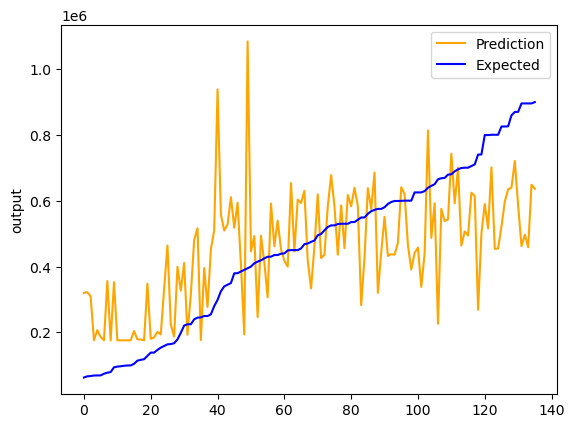

In [ ]:
score = model.evaluate([x_test, img_test, zipcode_test], y_test)
print("Test MSE:", score[1])

# Predictions and performance (RMSE)
predictions = model.predict([x_test, img_test, zipcode_test])
rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions))
print("RMSE:", rmse)

# R2 score
r2_score = metrics.r2_score(y_test, predictions)
print("R2 score:", r2_score)

# Plot Predictions vs Expected
chart_regression(predictions.flatten(), y_test.flatten())
